In [111]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

data = pd.read_csv('~/Downloads/data4a.csv')
fp = fm.FontProperties(fname='/Library/Fonts/Yu Gothic Medium.otf', size=12)

In [112]:
data.info()
print()
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
N    100 non-null int64
y    100 non-null int64
x    100 non-null float64
f    100 non-null object
dtypes: float64(1), int64(2), object(1)
memory usage: 3.2+ KB

           N           y           x
count  100.0  100.000000  100.000000
mean     8.0    5.080000    9.967200
std      0.0    2.743882    1.088954
min      8.0    0.000000    7.660000
25%      8.0    3.000000    9.337500
50%      8.0    6.000000    9.965000
75%      8.0    8.000000   10.770000
max      8.0    8.000000   12.440000


/Users/yusuke-nishioka/.anyenv/envs/pyenv/versions/3.5.2/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


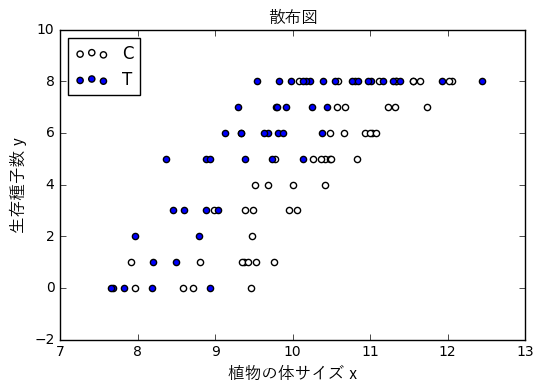

In [113]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(data.x[data.f=='C'], data.y[data.f=='C'], label='C', c='w')
ax.scatter(data.x[data.f=='T'], data.y[data.f=='T'], label='T')
ax.legend(loc='upper left')
ax.set_xlabel('植物の体サイズ x', fontproperties=fp)
ax.set_ylabel('生存種子数 y', fontproperties=fp)
ax.set_title('散布図', fontproperties=fp)
fig.show()

In [114]:
# statsmodelsでロジスティック回帰
import statsmodels.api as sm
import statsmodels.formula.api as smf
# 交互作用項なし
# Rだとformula=cbind(y, N-y) ~ x + fと書くが、statsmodelsだと以下のように書く
glm = smf.glm(
    formula='y + I(N - y) ~ x + f', data=data, family=sm.families.Binomial())
res = glm.fit()
print('aic: {}'.format(res.aic))
print(res.summary())
# 交互作用項あり
glm_with_interaction = smf.glm(
    formula='y + I(N - y) ~ x * f', data=data, family=sm.families.Binomial())
res_with_interaction = glm_with_interaction.fit()
print('aic: {}'.format(res_with_interaction.aic))
print(res_with_interaction.summary())

aic: 272.2111292852234
                 Generalized Linear Model Regression Results                  
Dep. Variable:      ['y', 'I(N - y)']   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -133.11
Date:                Sat, 10 Dec 2016   Deviance:                       123.03
Time:                        17:26:18   Pearson chi2:                     109.
No. Iterations:                     8                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    -19.5361      1.414    -13.818      0.000       -22.307   -16.765
f[T.T]         2.0215      0.

In [115]:
# scikit-learnでロジスティック回帰
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=False)
x = []
y = []
for idx, row in data.iterrows():
    d = {'x': row['x'], 'f': row['f']}
    pos_samples = row['y']
    neg_samples = N - pos_samples
    for i in range(0, pos_samples):
        x.append(d)
        y.append(1)
    for i in range(0, neg_samples):
        x.append(d)
        y.append(0)
X = dv.fit_transform(x)
lr = LogisticRegression()
lr.fit(X, np.array(y))
print('切片: {}'.format(lr.intercept_[0]))
print('係数: {}'.format(
    ['{}: {}'.format(dv.feature_names_[i], lr.coef_[0][i])
     for i in range(0, len(lr.coef_[0]))]
))

切片: -6.712913691186477
係数: ['f=C: -3.9713121050258526', 'f=T: -2.741601586160561', 'x: 1.0855867430923245']


/Users/yusuke-nishioka/.anyenv/envs/pyenv/versions/3.5.2/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


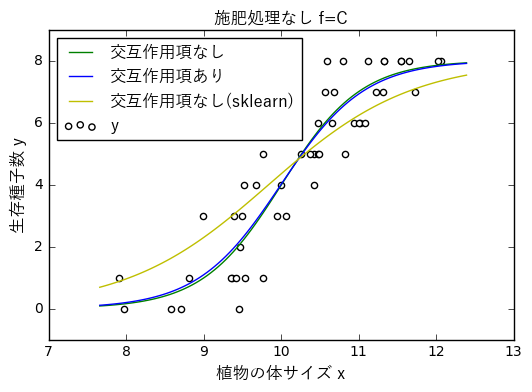

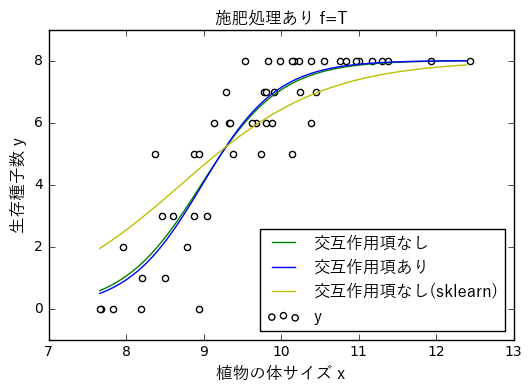

In [116]:
## N = 8
xrange = np.arange(min(data.x), max(data.x), (max(data.x) - min(data.x)) / 100)
# 施肥処理なし (f=C)
f = np.array(['C' for i in range(0, len(xrange))])
x_test = pd.DataFrame({'x': xrange, 'f': f})
x_test_for_sklearn = dv.transform(
    [{'x': xrange[i], 'f': f[i]} for i in range(0, len(xrange))]
)
y_test = res.predict(x_test)
y_test_with_interaction = res_with_interaction.predict(x_test)
y_test_for_sklearn = np.array([r[1] for r in lr.predict_proba(x_test_for_sklearn)])
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(data.x[data.f=='C'], data.y[data.f=='C'], c='w')
# 1 / (1 + np.exp(-(-19.5361 + 1.9524 * x)))
ax.plot(xrange, y_test * N, c='g', label='交互作用項なし')
# 1 / (1 + np.exp(-(-18.5233 + 1.8525 * x)))
ax.plot(xrange, y_test_with_interaction * N, c='b', label='交互作用項あり')
# 1 / (1 + np.exp(-(-6.7129 + 1.0856 * x - 3.9713)))
ax.plot(xrange, y_test_for_sklearn * N, c='y', label='交互作用項なし(sklearn)')
ax.set_xlabel('植物の体サイズ x', fontproperties=fp)
ax.set_ylabel('生存種子数 y', fontproperties=fp)
ax.legend(loc='best', fontsize=10, prop=fp)
ax.set_title('施肥処理なし f=C', fontproperties=fp)
fig.show()
# 施肥処理あり (f=T)
f = np.array(['T' for i in range(0, len(xrange))])
x_test = pd.DataFrame({'x': xrange, 'f': f})
x_test_for_sklearn = dv.transform(
    [{'x': xrange[i], 'f': f[i]} for i in range(0, len(xrange))]
)
y_test = res.predict(x_test)
y_test_with_interaction = res_with_interaction.predict(x_test)
y_test_for_sklearn = np.array([r[1] for r in lr.predict_proba(x_test_for_sklearn)])
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(data.x[data.f=='T'], data.y[data.f=='T'], c='w')
# 1 / (1 + np.exp(-(-19.5361 + 1.9524 * x + 2.0215)))
ax.plot(xrange, y_test * N, c='g', label='交互作用項なし')
# 1 / (1 + np.exp(-(-18.5233 + 1.8525 * x - 0.0638 + 0.2163 * x)))
ax.plot(xrange, y_test_with_interaction * N, c='b', label='交互作用項あり')
# 1 / (1 + np.exp(-(-6.7129 + 1.0856 * x - 2.7416)))
ax.plot(xrange, y_test_for_sklearn * N, c='y', label='交互作用項なし(sklearn)')
ax.set_xlabel('植物の体サイズ x', fontproperties=fp)
ax.set_ylabel('生存種子数 y', fontproperties=fp)
ax.legend(loc='lower right', fontsize=10, prop=fp)
ax.set_title('施肥処理あり f=T', fontproperties=fp)
fig.show()